In [89]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import Compose
import random


In [90]:
sample0, sr0 = librosa.load('Dataset-for-Binary/base-audio/audio_0.wav')

In [91]:
# waveform function for me to not bang my keyboard
def disp_waveform(signal, sr=None, color='blue'):
    plt.figure(figsize=(7,2))
    return librosa.display.waveshow(signal, sr=sr, color=color)

In [92]:
def isolator(signal, sample_rate, n_fft, hop_length, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        disp_waveform(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        disp_waveform(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        disp_waveform(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*hop_length) + n_fft//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            # strokes.append(torch.tensor(keystroke)[None, :])
            # keystroke = transform(keystroke)
            strokes.append(keystroke)
            if show:
                disp_waveform(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

In [93]:
# Constants we actually need for the task
MBP_AUDIO_DIR = 'Dataset-for-Binary/base-audio/'
# keys_s = '1234567890QWERTYUIOPASDFGHJKLZXCVBNM'
keys_s = '12'
labels = list(keys_s)
keys = ['audio_' + k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [94]:
def create_dataset(n_fft, hop_length, before, after):
    for i, File in enumerate(keys):
        loc = MBP_AUDIO_DIR + File
        samples, sr = librosa.load(loc)
        prom = 0.06
        step = 0.005
        strokes = isolator(samples, sr, n_fft, hop_length, before, after, prom, False )
        print(f'File {File} length: {len(strokes)}')
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace = True)

    return df

In [95]:
for key in keys_s:
    sample, sr = librosa.load(f'Dataset-for-Binary/base-audio/audio_{key}.wav')
    print(len(isolator(sample, sr, 1024, 225, 2400, 12000, 0.06)), end=' ')
    

25 25 

In [96]:
n_fft = 1024
hop_length = 225
before = 2400
after = 12000
mbp_dataset = create_dataset(n_fft, hop_length, before, after)
mbp_dataset

File audio_1.wav length: 25
File audio_2.wav length: 25


/var/folders/dr/8bpx1vc91zq76n48xvq00vkr0000gn/T/ipykernel_25558/2996179166.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Key': mapper}, inplace = True)


,Key,File
0,0,"[-0.00017975704, -0.00012727435, -9.371067e-05..."
1,0,"[0.0004975861, 0.00049031794, 0.00055128767, 0..."
2,0,"[0.0003178973, 0.00034715654, 0.00037197635, 0..."
3,0,"[0.0026817801, 0.0026667325, 0.0026979204, 0.0..."
4,0,"[0.006475482, 0.006330982, 0.0053669773, 0.003..."
5,0,"[0.0055401623, 0.0057142153, 0.0051255077, 0.0..."
6,0,"[-0.00901874, -0.0090894345, -0.007178737, -0...."
7,0,"[-0.00077488885, -0.00084206864, -0.0009062995..."
8,0,"[-0.00045609198, -0.00053762493, -0.0005696639..."
9,0,"[0.00048011309, 0.00049448083, 0.00048624963, ..."


In [97]:
audio_samples = mbp_dataset['File'].values.tolist()
labels = mbp_dataset['Key'].values.tolist()

audioDataset = np.array(audio_samples, dtype = object)
# labels = np.array(labels)

In [98]:
class TimeShifting():
    def __call__(self, samples):
#       samples_shape = samples.shape
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4) #Max shift (0.4)
        random_shift = random.randint(0, shift) #Random number between 0 and 0.4*len(samples)
        data_roll = np.roll(samples, random_shift)
        return data_roll

In [99]:
def time_shift(samples):
    samples = samples.flatten()
    shift = int(len(samples) * 0.4) #Max shift (0.4)
    random_shift = random.randint(0, shift) #Random number between 0 and 0.4*len(samples)
    data_roll = np.roll(samples, random_shift)
    return data_roll

In [100]:
from skimage.transform import resize


class ToMelSpectrogram:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=1024, hop_length=225)
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)
        return torch.tensor(mel_spec_resized)


class ToMelSpectrogramMfcc:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=n_fft, hop_length=hop_length)
        mel_spec = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec))
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)

        return torch.tensor(mel_spec_resized)


In [101]:
transform = Compose([ToMelSpectrogramMfcc()])

In [102]:
audio_samples_new = audio_samples.copy()

for i, sample in enumerate(audio_samples):
    audio_samples_new.append(time_shift(sample))
    labels.append(labels[i])

# convert labels to a numpy array
labels = np.array(labels)
print(len(audio_samples_new))
print(len(labels))

100
100


In [103]:
audioDatasetFin = []

for i in range(len(audio_samples_new)):
    transformed_sample = transform(audio_samples_new[i])

    audioDatasetFin.append((transformed_sample, labels[i]))

In [104]:
len(audioDatasetFin)

100

In [105]:
# Model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [106]:
import time

def train(dataset, num_epochs, model_path, leave_one_out=False):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    if leave_one_out:
        train_set, val_set = dataset[:-1], [dataset[-1]]
    else:
        train_set, val_set = train_test_split(dataset, test_size=0.15)
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=16, shuffle=True)
    
    model = CNN()
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-5)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.BCELoss()
    # criterion = nn.BCEWithLogitsLoss()
    
    num_correct_vals = 0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0  # correct training examples
        total_train = 0 # total training examples
        tic = time.perf_counter()
        
        # print(f'---- EPOCH {epoch} ----')
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1).float()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item() * inputs.size(0)

            # _, predicted_train = torch.max(outputs.data, 1)
            predicted_train = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
        toc = time.perf_counter()
        time_taken = toc - tic
        
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Evaluation of the model
        model.eval()
        total, correct = 0, 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1).float()
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            # _, predicted = torch.max(outputs.data, 1)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # print("VALIDATION")
            # print(f'outputs: {outputs}')
            # print(f'predicted: {predicted}')
            # print(f'labels: {labels}')
            
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        
        if val_accuracy > 0.90:
            num_correct_vals += 1
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} / Val Accuracy: {val_accuracy:.4f} Iter Time: {time_taken:.2f}s")
        
        if epoch == num_epochs - 1 and epoch != 0:
            plt.plot(range(epoch+1), train_accuracies, label='Training Accuracy', color="blue")
            plt.plot(range(epoch+1), val_accuracies, label='Validation Accuracy', color="orange")
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title(f'Training vs Validation Accuracy')
            plt.legend()
            plt.show()
        
        print()
    print(f'Number of correct validations: {num_correct_vals}/{num_epochs}')
    torch.save(model.state_dict(), model_path)

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/40], Train Loss: 4.0713, Train Accuracy: 0.3535 / Val Accuracy: 1.0000 Iter Time: 4.17s

Epoch [2/40], Train Loss: 0.9418, Train Accuracy: 0.5960 / Val Accuracy: 1.0000 Iter Time: 0.06s

Epoch [3/40], Train Loss: 0.5772, Train Accuracy: 0.6162 / Val Accuracy: 1.0000 Iter Time: 0.05s

Epoch [4/40], Train Loss: 0.4307, Train Accuracy: 0.8384 / Val Accuracy: 1.0000 Iter Time: 0.04s

Epoch [5/40], Train Loss: 0.3508, Train Accuracy: 0.8788 / Val Accuracy: 1.0000 Iter Time: 0.05s

Epoch [6/40], Train Loss: 0.2912, Train Accuracy: 0.9192 / Val Accuracy: 0.0000 Iter Time: 0.05s

Epoch [7/40], Train Loss: 0.3044, Train Accuracy: 0.8586 / Val Accuracy: 1.0000 Iter Time: 0.05s

Epoch [8/40], Train Loss: 0.1940, Train Accuracy: 0.9394 / Val Accuracy: 1.0000 Iter Time: 0.05s

Epoch [9/40], Train Loss: 0.1900, Train Accuracy: 0.9293 / Val Accuracy: 1.0000 Iter Time: 0.05s

Epoch [10/40], Train Loss: 0.1660, Train Accuracy: 0.9596 / Val Accuracy: 1.0000 Iter Time: 0.05s

Epoch [11/40], Trai

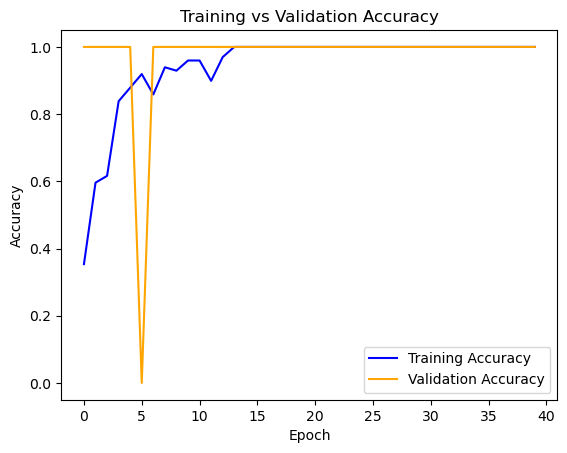


Number of correct validations: 39/40


In [107]:
train(audioDatasetFin, 40, "model_binclass_cnn_08_08_24.pth", leave_one_out=True)